## Chloe's Explore Notebook for the NLP Group Project

### Imports

In [1]:
import pandas as pd
import numpy as np

# Scraping
import requests
from bs4 import BeautifulSoup

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import nltk.sentiment

from wordcloud import WordCloud

# Regex
import re

# Time
from time import strftime

import unicodedata
import json
from pprint import pprint

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Imports
import acquire 
from prepare import *

# Turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

# pd.set_option('display.max_colwidth', -1)

### Acquire

In [2]:
# acquire.scrape_github_data()

In [3]:
# df = pd.DataFrame(acquire.scrape_github_data(),columns=['repo','language','readme_contents'])
# df.head()


In [4]:
df = pd.read_json('repo_readmes.json')

In [5]:
df.shape

(960, 3)

In [6]:
original = pd.read_json('repo_readmes.json')
print(original)

                              repo    language  \
0                  bitcoin/bitcoin         C++   
1          bitcoinbook/bitcoinbook    AsciiDoc   
2                bitcoinj/bitcoinj        Java   
3                     bitcoin/bips    Wikitext   
4          bitcoinjs/bitcoinjs-lib  TypeScript   
..                             ...         ...   
955              spesmilo/electrum      Python   
956  bitcoin-wallet/bitcoin-wallet        Java   
957        etotheipi/BitcoinArmory         C++   
958    bitcoin-dot-org/Bitcoin.org        HTML   
959               jgarzik/cpuminer           C   

                                       readme_contents  
0    Bitcoin Core integration/staging tree\n=======...  
1    Code Examples: ![travis_ci](https://travis-ci....  
2    [![Github Build Status](https://github.com/bit...  
3    People wishing to submit BIPs, first should pr...  
4    # BitcoinJS (bitcoinjs-lib)\n[![Github CI](htt...  
..                                                 ...  


### Prepare

In [7]:
df.head()

,repo,language,readme_contents
0,bitcoin/bitcoin,C++,Bitcoin Core integration/staging tree\n=======...
1,bitcoinbook/bitcoinbook,AsciiDoc,Code Examples: ![travis_ci](https://travis-ci....
2,bitcoinj/bitcoinj,Java,[![Github Build Status](https://github.com/bit...
3,bitcoin/bips,Wikitext,"People wishing to submit BIPs, first should pr..."
4,bitcoinjs/bitcoinjs-lib,TypeScript,# BitcoinJS (bitcoinjs-lib)\n[![Github CI](htt...


In [8]:
# if you want to see the whole column contents:
# pd.set_option('display.max_colwidth', -1)

In [18]:
# how many language observations do we have?

df.language.value_counts(normalize = True)

C++           0.2
Java          0.2
AsciiDoc      0.1
TypeScript    0.1
C             0.1
Wikitext      0.1
HTML          0.1
Python        0.1
Name: language, dtype: float64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 960 entries, 0 to 959
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             960 non-null    object
 1   language         960 non-null    object
 2   readme_contents  960 non-null    object
dtypes: object(3)
memory usage: 30.0+ KB


Split data since we will be modeling. 

In [11]:
# SPLIT
from sklearn.model_selection import train_test_split
# Test set is .2 of original dataframe
train, test = train_test_split(df, test_size = .2, random_state=123, stratify= df.language)
# The remainder is here divided .7 to train and .3 to validate
train, validate = train_test_split(train, test_size=.3, random_state=123, stratify= train.language)
train.shape, validate.shape, test.shape

((537, 3), (231, 3), (192, 3))

In [19]:
# how many language observations do we have?

train.language.value_counts(normalize = True)

C++           0.199255
Java          0.199255
TypeScript    0.100559
C             0.100559
AsciiDoc      0.100559
HTML          0.100559
Python        0.100559
Wikitext      0.098696
Name: language, dtype: float64

In [20]:
# combine all contents in single string by language

java_words = basic_clean(' '.join(train[train.language == 'Java'].readme_contents))
c_plus_plus__words = basic_clean(' '.join(train[train.language == 'C++'].readme_contents))
wiki_words = basic_clean(' '.join(train[train.language == 'Wikitext'].readme_contents))
type_words = basic_clean(' '.join(train[train.language == 'TypeScript'].readme_contents))
c_words = basic_clean(' '.join(train[train.language == 'C'].readme_contents))
ascii_words = basic_clean(' '.join(train[train.language == 'AsciiDoc'].readme_contents))
python_words = basic_clean(' '.join(train[train.language == 'Python'].readme_contents))
html_words = basic_clean(' '.join(train[train.language == 'HTML'].readme_contents))
all_words = basic_clean(' '.join(train.readme_contents))

In [21]:
# all_words

### Explore

In [22]:
# represent contents as word frequencies

java_freq = pd.Series(java_words.split()).value_counts()
c_plus_plus_freq = pd.Series(c_plus_plus__words.split()).value_counts()
wiki_freq = pd.Series(wiki_words.split()).value_counts()
type_freq = pd.Series(type_words.split()).value_counts()
c_freq = pd.Series(c_words.split()).value_counts()
ascii_freq = pd.Series(ascii_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
html_freq = pd.Series(html_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [23]:
# concat all frequencies together into a dataframe

word_counts = pd.concat([java_freq, c_plus_plus_freq, wiki_freq, type_freq, c_freq, ascii_freq, python_freq, html_freq, all_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['java', 'c_plus_plus', 'wiki', 'typescript', 'c', 'asciidoc', 'python', 'html', 'all']
word_counts.head()

,java,c_plus_plus,wiki,typescript,c,asciidoc,python,html,all
the,2477,2048,530,2106,54,1350,918,432,9915
and,1263,1397,530,2376,108,594,162,108,6538
to,1104,1122,318,1458,108,702,486,162,5460
for,911,1027,1696,918,108,216,162,54,5092
a,847,474,583,3132,54,972,216,324,6602


- What are the most frequently occuring words? 

- Are there words that uniquely identify with a certain language's repos? 


In [24]:
# most frequently occuring words: sort by 'all'

word_counts.sort_values('all', ascending=False).head(20)

,java,c_plus_plus,wiki,typescript,c,asciidoc,python,html,all
the,2477,2048,530,2106,54,1350,918,432,9915
a,847,474,583,3132,54,972,216,324,6602
and,1263,1397,530,2376,108,594,162,108,6538
standard,0,0,6466,0,0,0,0,0,6466
to,1104,1122,318,1458,108,702,486,162,5460
stylebackgroundcolor,0,0,5300,0,0,0,0,0,5300
for,911,1027,1696,918,108,216,162,54,5092
of,526,593,742,864,0,648,162,216,3751
is,318,1091,106,810,162,486,486,54,3513
applications,52,0,3339,0,0,0,0,0,3391


In [25]:
# requently occuring words by language: sort by language
word_counts.sort_values(['java', 'c_plus_plus', 'wiki', 'typescript', 'c', 'asciidoc', 'python', 'html'], ascending=[True, True, True, True, True, True, True, True]).sample(20)

,java,c_plus_plus,wiki,typescript,c,asciidoc,python,html,all
bypassing,0,0,0,54,0,0,0,0,54
pure,0,0,0,0,0,0,108,0,108
commands,52,0,0,0,0,0,0,0,52
amir,0,0,265,0,0,0,0,0,265
bip0065mediawiki65,0,0,53,0,0,0,0,0,53
coalescing,0,0,53,0,0,0,0,0,53
bech32httpsgithubcombitcoinjsbech32,0,0,0,54,0,0,0,0,54
fundamentally,0,0,0,54,0,0,0,0,54
bounties,0,0,0,0,0,0,0,54,54
standardized,0,0,0,54,0,0,0,0,54


- python vs Java for 20 most common words

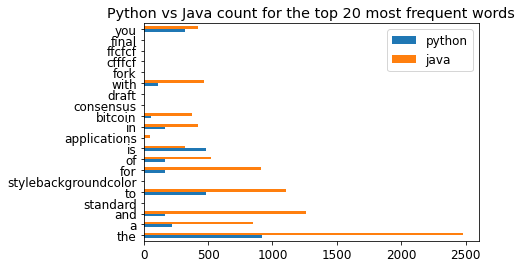

In [47]:
plt.rc('font', size=12)
word_counts.sort_values('all', ascending=False).head(20)[['python', 'java']].plot.barh()
plt.title('Python vs Java count for the top 20 most frequent words');

- C++ vs Java for 20 most common words

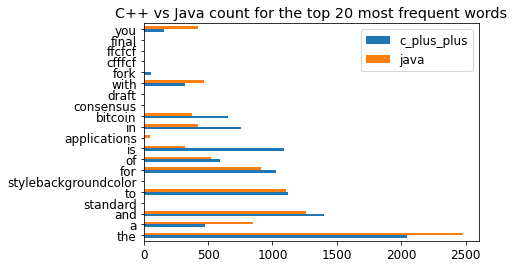

In [48]:
plt.rc('font', size=12)
word_counts.sort_values('all', ascending=False).head(20)[['c_plus_plus', 'java']].plot.barh()
plt.title('C++ vs Java count for the top 20 most frequent words');

- Wikitext vs Java for 20 most common words

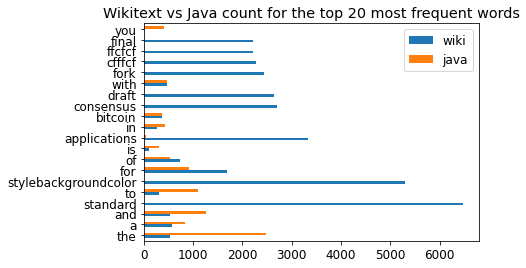

In [49]:
plt.rc('font', size=12)
word_counts.sort_values('all', ascending=False).head(20)[['wiki', 'java']].plot.barh()
plt.title('Wikitext vs Java count for the top 20 most frequent words');

- Wikitext vs TypeScript for 20 most common words

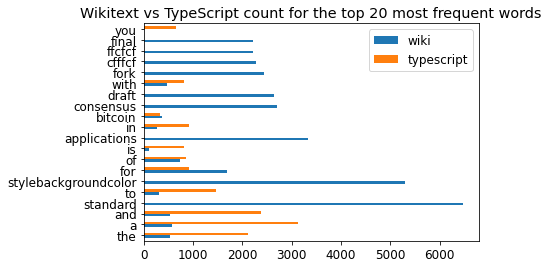

In [50]:
plt.rc('font', size=12)
word_counts.sort_values('all', ascending=False).head(20)[['wiki', 'typescript']].plot.barh()
plt.title('Wikitext vs TypeScript count for the top 20 most frequent words');

- Wikitext vs C for 20 most common words

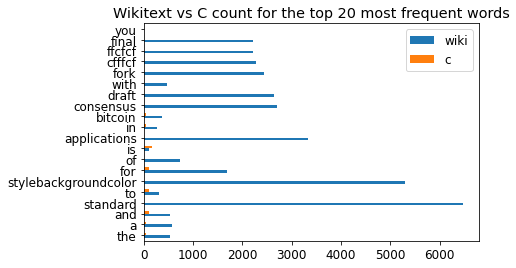

In [51]:
plt.rc('font', size=12)
word_counts.sort_values('all', ascending=False).head(20)[['wiki', 'c']].plot.barh()
plt.title('Wikitext vs C count for the top 20 most frequent words');

- Wikitext vs AsciiDoc for 20 most common words

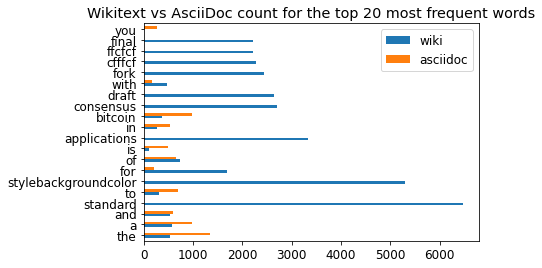

In [52]:
plt.rc('font', size=12)
word_counts.sort_values('all', ascending=False).head(20)[['wiki', 'asciidoc']].plot.barh()
plt.title('Wikitext vs AsciiDoc count for the top 20 most frequent words');

- Wikitext vs HTML for 20 most common words

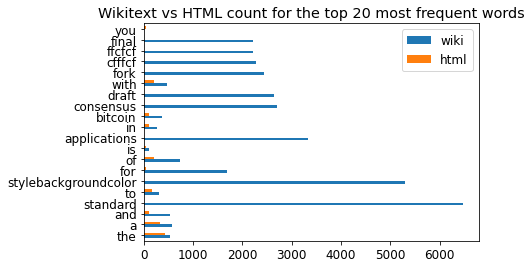

In [53]:
plt.rc('font', size=12)
word_counts.sort_values('all', ascending=False).head(20)[['wiki', 'html']].plot.barh()
plt.title('Wikitext vs HTML count for the top 20 most frequent words');

- % of Wikitext vs all for 20 most common words

<Figure size 1440x648 with 0 Axes>

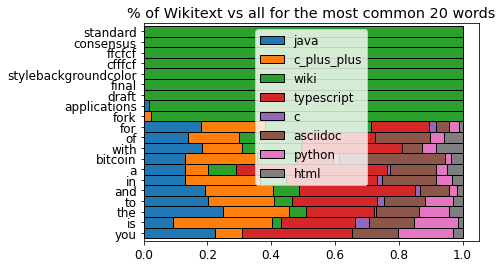

In [65]:
plt.figure(figsize=(20, 9))
plt.rc('font', size=12)

(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'wiki')
 .plot.barh(stacked = True, width = 1, ec = 'k')
)
plt.title('% of Wikitext vs all for the most common 20 words');

- exploring n-grams
    - what are the most common bigrams? 
    - most common bigrams by language

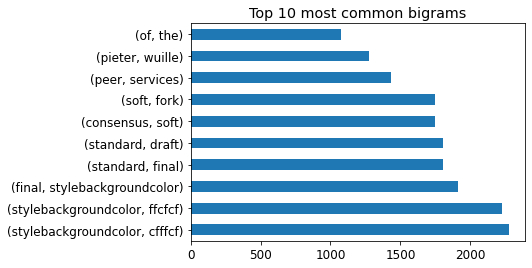

In [64]:
# most common bigrams

pd.Series(nltk.bigrams(all_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common bigrams');

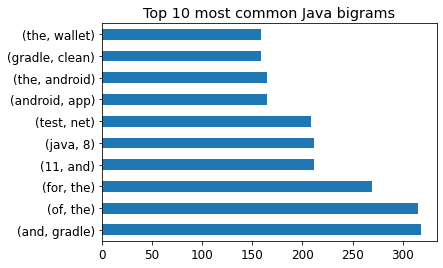

In [76]:
# most common Java bigrams

pd.Series(nltk.bigrams(java_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common Java bigrams');

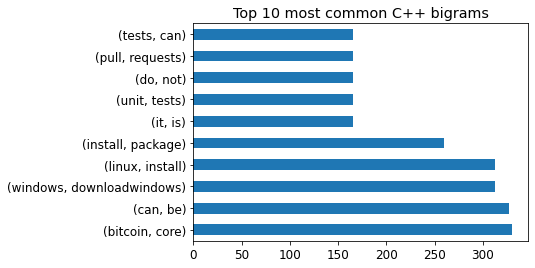

In [68]:
# most common C++ bigrams

pd.Series(nltk.bigrams(c_plus_plus__words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common C++ bigrams');

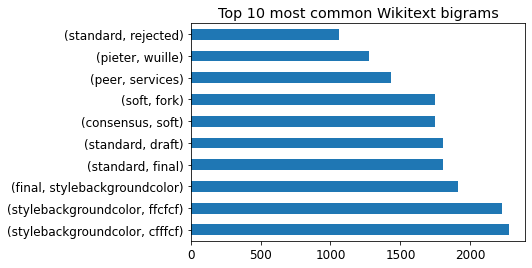

In [69]:
# most common Wikitext bigrams

pd.Series(nltk.bigrams(wiki_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common Wikitext bigrams');

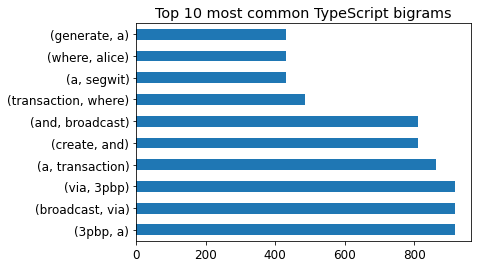

In [70]:
# most common TypeScript bigrams

pd.Series(nltk.bigrams(type_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common TypeScript bigrams');

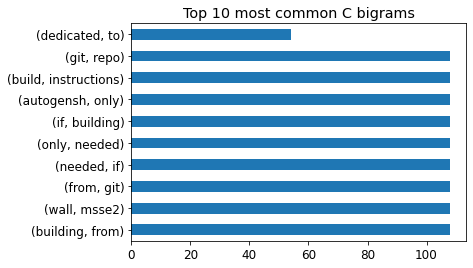

In [71]:
# most common C bigrams

pd.Series(nltk.bigrams(c_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common C bigrams');

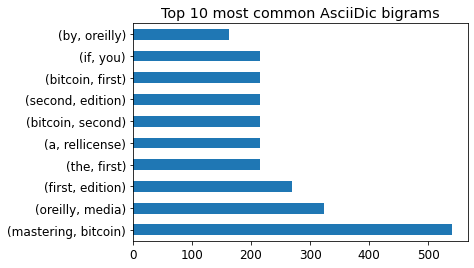

In [73]:
# most common AsciiDoc bigrams

pd.Series(nltk.bigrams(ascii_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common AsciiDic bigrams');

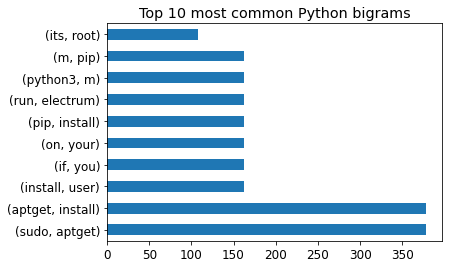

In [74]:
# most common Python bigrams

pd.Series(nltk.bigrams(python_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common Python bigrams');

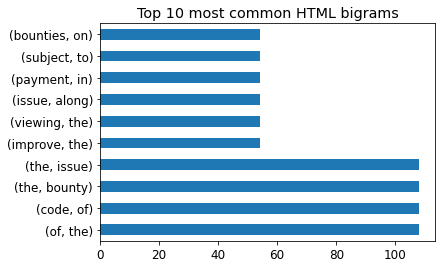

In [75]:
# most common HTML bigrams

pd.Series(nltk.bigrams(html_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common HTML bigrams');

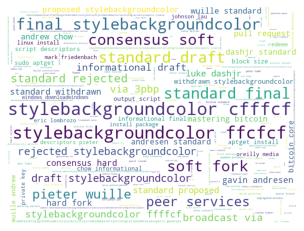

In [78]:
from wordcloud import WordCloud
img = WordCloud(background_color='white', width=800, height=600).generate(all_words)
plt.imshow(img)
plt.axis('off');